
Below, we import some standard libraries.

In [ ]:
# Standard libraries
import math
import os
import urllib.request
from functools import partial
from urllib.error import HTTPError
from tqdm.notebook import tqdm
import random

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


%matplotlib inline

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/"

# Set seed to ensure that all operations are deterministic for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


Let's now write a function computing the output features given the triple of queries, keys, and values:

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]

    # Compute attn_logits
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits /= math.sqrt(d_k)

    # Apply mask if not None
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, - 1e14)

    # Pass through softmax
    attention = F.softmax(attn_logits, dim=-1)

    # Weight values accordingly
    output_values = torch.matmul(attention, v)

    return output_values, attention

Note that our code above supports any additional dimensionality in front of the sequence length
so that we can also use it for batches.
However, for a better understanding, let's generate a few random queries, keys, and value vectors,
and calculate the attention outputs:

In [ ]:
q = torch.tensor([[-0.8920, -1.5091],
        [ 0.3704,  1.4565],
        [ 0.9398,  0.7748]])
k = torch.tensor([[ 0.1919,  1.2638],
        [-1.2904, -0.7911],
        [-0.0209, -0.7185]])
v = torch.tensor([[ 0.5186, -1.3125],
        [ 0.1920,  0.5428],
        [-2.2188,  0.2590]])

output_values, attention = scaled_dot_product(q, k, v)

print("Output\n", output_values)
print("Attention\n", attention)

assert (output_values - torch.tensor([[-0.4846,  0.4063],
                                      [ 0.2174, -1.0264],
                                      [-0.0766, -0.8279]]) < 1e-4).all(), \
    f"Error in computing the attention"
assert (attention - torch.tensor([[0.0300, 0.6852, 0.2847],
                                  [0.8302, 0.0678, 0.1019],
                                  [0.7071, 0.0857, 0.2072]]) < 1e-4).all(), \
    f"Error in computing the attention"

Output
 tensor([[-0.4846,  0.4063],
        [ 0.2174, -1.0264],
        [-0.0766, -0.8279]])
Attention
 tensor([[0.0300, 0.6852, 0.2847],
        [0.8302, 0.0678, 0.1019],
        [0.7071, 0.0857, 0.2072]])


### Multi-Head Attention

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim # dimension of concatenated heads
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads


        # Create linear layers for both qkv and output
        # TIP: Stack all weight matrices 1...h together for efficiency
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self.qkv_proj = nn.Linear(input_dim,embed_dim*3)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):

        batch_dim, seq_length, input_dim = x.shape

        # Compute linear projection for qkv and separate heads
        # QKV: [Batch, Head, SeqLen, Dims]
        qkv = self.qkv_proj(x)
        qkv=qkv.reshape(batch_dim, seq_length, self.num_heads, 3*self.head_dim)
        qkv=qkv.permute(0,2,1,3)
        q, k, v = torch.chunk(qkv,3,dim=-1)


        # Apply Dot Product Attention to qkv ()
        attention_values, attention = scaled_dot_product(q,k,v)

        # Concatenate heads to [Batch, SeqLen, Embed Dim]
        attention_values = attention_values.permute(0,2,1,3)
        attention_values = attention_values.reshape(batch_dim,seq_length,self.embed_dim)

        # Output projection
        o = self.o_proj(attention_values)

        if return_attention:
            return o, attention
        else:
            return o

input_d = 3
seq_l = 4
embed_d = 4
n_heads = 2
b_size = 1

mh_att = MultiheadAttention(input_d, embed_d, n_heads)

x = torch.rand(b_size, seq_l, input_d)
x = torch.tensor([[[0.3360, 0.6676, 0.6393],
         [0.2083, 0.5484, 0.1204],
         [0.3533, 0.3038, 0.9383],
         [0.0499, 0.2048, 0.0107]]])
print(f"Input x: {x}")

att_output = mh_att(x)
print(f"MhA Output {att_output}")
print(att_output.shape)
assert att_output.shape == torch.Size([1, 4, 4]), "Error in computing multi-head attention"

Input x: tensor([[[0.3360, 0.6676, 0.6393],
         [0.2083, 0.5484, 0.1204],
         [0.3533, 0.3038, 0.9383],
         [0.0499, 0.2048, 0.0107]]])
MhA Output tensor([[[-0.0996,  0.8360, -0.1902, -0.0828],
         [-0.1006,  0.8359, -0.1943, -0.0854],
         [-0.1060,  0.8562, -0.1935, -0.0849],
         [-0.1069,  0.8535, -0.2007, -0.0894]]], grad_fn=<ViewBackward0>)
torch.Size([1, 4, 4])


### Transformer Encoder

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Create Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Create Two-layer MLP with droput
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2*input_dim, input_dim)
        )
        # Layers to apply in between the main layers (Layer Norm and Dropout)
        self.norm = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        # Compute Attention part
        attn = self.self_attn(x)
        x = self.norm(x+attn)

        # Compute MLP part
        x = self.norm(x+self.mlp(x))

        return x



Based on this block, we can implement a module for the full **Transformer encoder**.
Additionally to a `forward` function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`.
The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder.
They helps us in understanding, and partially, explaining the model.
Attention scores may not necessarily reflect the true interpretation of the model

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps

### Positional encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args
            d_model: Hidden dimensionality of the input.
            max_len: Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

To understand the positional encoding, we can visualize it below.
We will generate an image of the positional encoding over hidden dimensionality and position in a sequence.
Each pixel, therefore, represents the change of the input feature we perform to encode the specific position.

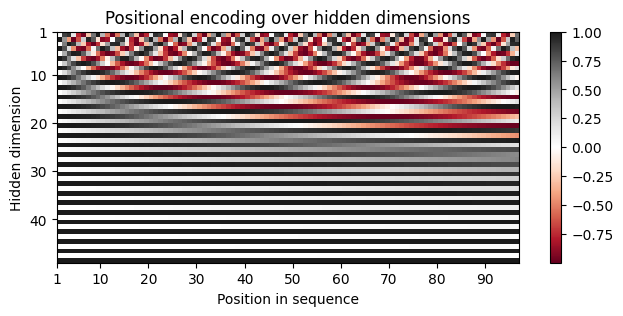

In [ ]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

### Transformer Encoder Classifier

Finally, we can implement a template for a classifier based on the Transformer encoder.

Additionally to the Transformer architecture, we add:
* a small input network (maps input dimensions to model dimensions)
* the positional encoding
* an output network (transforming output encodings to predictions).

The output network will take in input a 3D tensor `<batch_samples, seq_len, model_dim>` and produce in output another 2D tensor `<batch_samples, seq_len>` where each output value represents the prediction of the corresponding reversed number.

In [ ]:
class TransformerPredictor(nn.Module):
    def __init__(
        self,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """
        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.input_dropout = input_dropout

        # Create a Generic Input Encoder Input dim -> Model dim with input dropout
        self.input_net = nn.Sequential(
            nn.Linear(input_dim, model_dim),
            nn.Dropout(input_dropout)
        )

        # Create positional encoding for sequences
        self.positional_encoding = PositionalEncoding(model_dim,max_len=16)

        # Create transformer Encoder
        self.transformer = TransformerEncoder(num_layers, input_dim=model_dim, dim_feedforward=model_dim*2, num_heads=num_heads, dropout=dropout)

        # Create output classifier per sequence element Model_dim -> num_classes
        self.output_net = nn.Linear(model_dim, num_classes)

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)

        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps



## Experiment: Sequence to Sequence

First, let's create a dataset class below.

In [ ]:
class ReverseDataset(data.Dataset):
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`.
The label is simply the tensor flipped over the sequence dimension.
We can create the corresponding data loaders below.

In [ ]:
dataset = partial(ReverseDataset, 10, 16)
train_dl = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_dl = data.DataLoader(dataset(1000), batch_size=128)
test_dl = data.DataLoader(dataset(10000), batch_size=128)

Let's look at an arbitrary sample of the dataset:

In [ ]:
inp_data, labels = train_dl.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([2, 5, 7, 2, 5, 4, 4, 2, 5, 7, 0, 9, 8, 7, 6, 6])
Labels:     tensor([6, 6, 7, 8, 9, 0, 7, 5, 2, 4, 4, 5, 2, 7, 5, 2])


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token.
We use the standard Cross-Entropy loss to perform this.
Every number is represented as a one-hot vector.
Representing the categories as single scalars decreases the expressiveness of the model extremely
as $0$ and $1$ are not closer related than $0$ and $9$ in our example.
An alternative to a one-hot vector is using a learned embedding vector as it is provided by the PyTorch module `nn.Embedding`.
However, using a one-hot vector with an additional linear layer as in our case has the same effect
as an embedding layer (`self.input_net` maps one-hot vector to a dense vector,
where each row of the weight matrix represents the embedding for a specific category).

To implement the training dynamic, we create a new class inheriting from `TransformerPredictor`
and overwriting the training, validation and test step functions.

In [ ]:
def train_step(model, x, y, optim):
    model.train()

    # Fetch data and transform categories to one-hot vectors
    inp_data = F.one_hot(x, num_classes=model.num_classes).float()

    # Perform prediction and calculate loss and accuracy
    preds = model(inp_data, add_positional_encoding=True)
    loss = F.cross_entropy(preds.view(-1, preds.size(-1)), y.view(-1))
    acc = (preds.argmax(dim=-1) == y).float().mean()

    # Backpropagate and update weights
    loss.backward()
    optim.step()
    model.zero_grad()

    return loss, acc

def eval_step(model, x, y):
    with torch.no_grad():
        model.eval()

        # Fetch data and transform categories to one-hot vectors
        inp_data = F.one_hot(x, num_classes=model.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = model(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), y.view(-1))
        acc = (preds.argmax(dim=-1) == y).float().mean()

    return loss, acc


Finally, we can create a training function similar to the one we have seen in previous laboratories. We running for $N$ epochs printing the training and validation loss and saving our best model based on the validation.
Afterward, we test our models on the test set.

In [ ]:
def train_model(model, train_loader, val_loader, test_loader,
                optim, epochs=5):
    best_acc = 0.
    pbar = tqdm(range(epochs))
    for e in range(epochs):
        train_loss, train_acc = 0., 0.
        for x, y in train_loader:
            loss, acc = train_step(model, x, y, optim)
            train_loss += loss
            train_acc += acc

        val_loss, val_acc = 0., 0.
        for x, y in val_loader:
            loss, acc = eval_step(model, x, y)
            val_loss += loss
            val_acc += acc

        if val_acc/len(val_loader) > best_acc:
            torch.save(model.state_dict(), "best_model.pt")
            best_acc = val_acc/len(val_loader)

        pbar.update()
        pbar.set_description(f"Train Acc: {train_acc/len(train_loader)* 100:.2f} "
                            f"Train Loss: {train_loss/len(train_loader):.2f} "
                            f"Val Acc: {val_acc/len(val_loader)* 100 :.2f}  "
                            f"Val loss: {val_loss/len(val_loader):.2f} ")

    test_loss, test_acc = 0., 0.
    for x, y in test_loader:
        loss, acc = eval_step(model, x, y)
        test_loss += loss
        test_acc += acc

    print(f"Test accuracy: {test_acc/len(test_loader)*100 :.2f}")

    pbar.close()
    model.load_state_dict(torch.load("best_model.pt"))

    return model

Finally, we can train the model.
In this setup, we will use a single encoder block and a single head in the Multi-Head Attention.
This is chosen because of the simplicity of the task, and in this case, the attention can actually be interpreted
as an "explanation" of the predictions (compared to the other papers above dealing with deep Transformers).

In [ ]:
reverse_model = TransformerPredictor(
    input_dim=train_dl.dataset.num_categories,
    model_dim=32,
    num_heads=1,
    num_classes=train_dl.dataset.num_categories,
    num_layers=1,
    dropout=0.0,
)
optimizer = optim.AdamW(reverse_model.parameters(), lr=0.001)

reverse_model = train_model(reverse_model, train_dl, val_dl, test_dl, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

Test accuracy: 100.00


As we would have expected, the Transformer can correctly solve the task.
However, how does the attention in the Multi-Head Attention block looks like for an arbitrary input?
Let's try to visualize it below.

In [ ]:
data_input, labels = next(iter(val_dl))
inp_data = F.one_hot(data_input, num_classes=reverse_model.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

The object `attention_maps` is a list of length $N$ where $N$ is the number of layers.
Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.

In [ ]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

Next, we will write a plotting function that takes as input the sequences, attention maps, and an index
indicating for which batch element we want to visualize the attention map.
We will create a plot where over rows, we have different layers, while over columns, we show the different heads.
Remember that the softmax has been applied for each row separately.

In [ ]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin="lower", vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title("Layer %i, Head %i" % (row + 1, column + 1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()

Finally, we can plot the attention map of our trained Transformer on the reverse task:

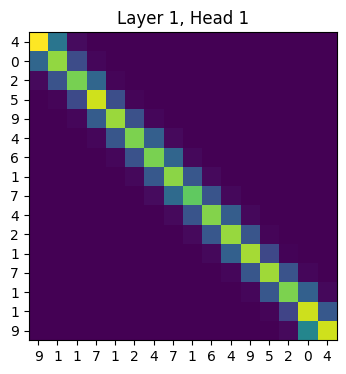

In [ ]:
plot_attention_maps(data_input, attention_maps, idx=0)

The model has learned to attend to the token that is on the flipped index of itself.
Hence, it actually does what we intended it to do.
We see that it however also pays some attention to values close to the flipped index.
This is because the model doesn't need the perfect, hard attention to solve this problem,
but is fine with this approximate, noisy attention map.
The close-by indices are caused by the similarity of the positional encoding,
which we also intended with the positional encoding.